In [2]:
import os
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

C:\Users\multicampus\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
# csv_test = pd.read_csv('answer.csv')

df_movies = pd.read_csv('movies.csv')
df_ratings = pd.read_csv('ratings.csv')

In [4]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
movieId    9742 non-null int64
title      9742 non-null object
genres     9742 non-null object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [5]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
userId       100836 non-null int64
movieId      100836 non-null int64
rating       100836 non-null float64
timestamp    100836 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [6]:
df_movies.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [7]:
df_ratings.head()

userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

In [8]:
num_users = len(df_ratings.userId.unique())
num_items=len(df_ratings.movieId.unique())
print(num_users,num_items)

610 9724


In [9]:
# we first need to get the counts of each rating from ratings data
# get count
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

count
rating       
0.5      1370
1.0      2811
1.5      1791
2.0      7551
2.5      5550
3.0     20047
3.5     13136
4.0     26818
4.5      8551
5.0     13211

In [10]:
'''
We can see that above table does not include counts of zero rating score
So we need to add that in rating count dataframe as well
0을 넣어야해~!~!~!
'''
# there are a lot more counts in rating of zero
total_cnt = num_users * num_items
print(total_cnt,df_ratings.shape[0])
rating_zero_cnt = total_cnt - df_ratings.shape[0]

# append counts of zero rating to df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

5931640 100836


count
0.0  5830804
0.5     1370
1.0     2811
1.5     1791
2.0     7551
2.5     5550
3.0    20047
3.5    13136
4.0    26818
4.5     8551
5.0    13211

In [11]:
'''
he count for zero rating score is too big to compare with others.
So let's take log transform for count values and then we can plot them to compare
'''

# add log count
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt


count  log_count
0.0  5830804  15.578665
0.5     1370   7.222566
1.0     2811   7.941296
1.5     1791   7.490529
2.0     7551   8.929435
2.5     5550   8.621553
3.0    20047   9.905835
3.5    13136   9.483112
4.0    26818  10.196829
4.5     8551   9.053804
5.0    13211   9.488805

Text(0, 0.5, 'number of ratings')

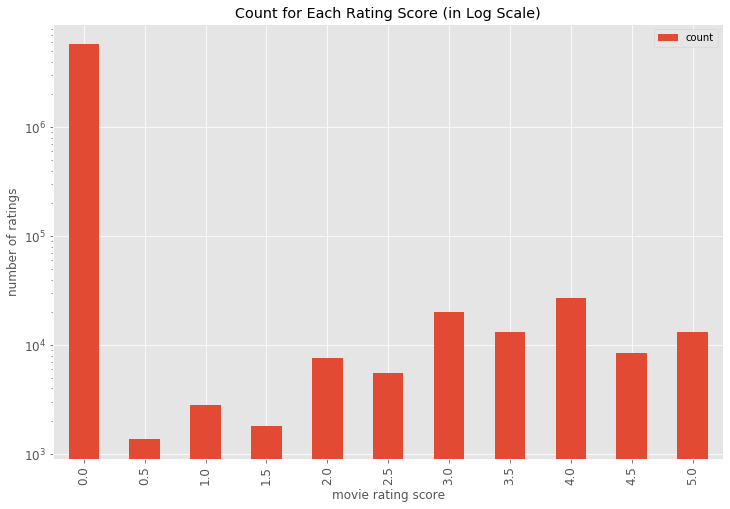

In [12]:

ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")
#평점별 갯수

In [13]:
df_ratings.head()

userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

In [14]:
# get rating frequency
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

count
movieId       
1          215
2          110
3           52
4            7
5           49

Text(0, 0.5, 'number of ratings')

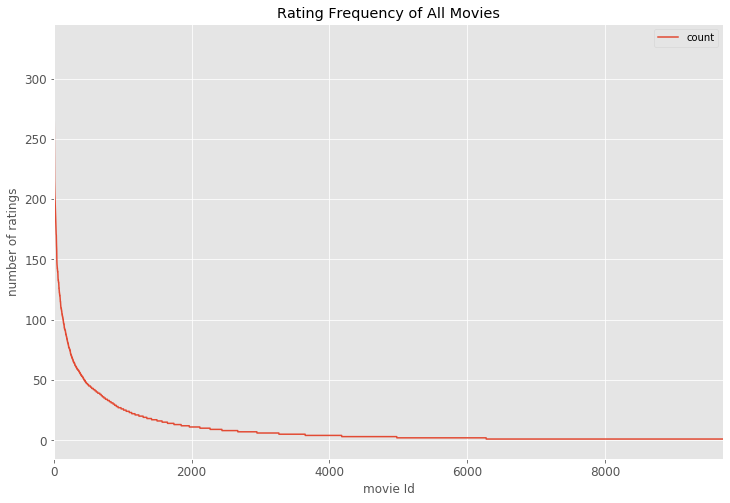

In [15]:
# plot rating frequency of all movies
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")
#영화 들의 평점 흐름을 보자

Text(0, 0.5, 'number of ratings (log scale)')

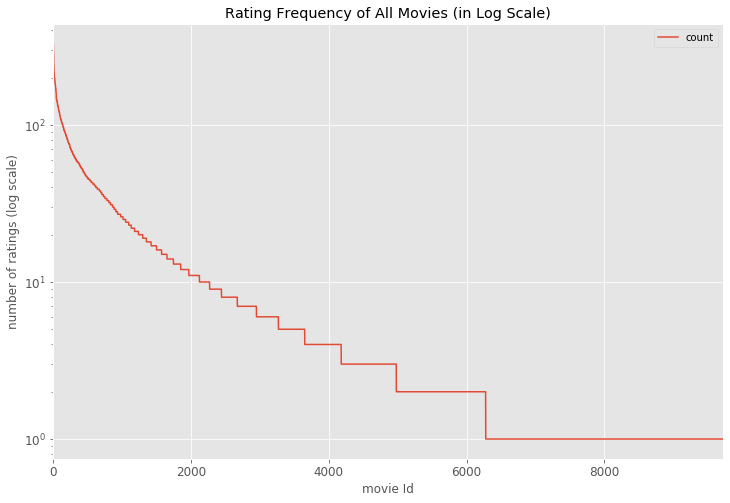

In [16]:
'''
The distribution of ratings among movies often satisfies a property in real-world settings, 
which is referred to as the long-tail property. 
According to this property, only a small fraction of the items are rated frequently.
Such items are referred to as popular items. 
The vast majority of items are rated rarely. 
This results in a highly skewed distribution of the underlying ratings.

Let's plot the same distribution but with log scale
'''
# plot rating frequency of all movies in log scale
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings (log scale)")

In [17]:
#  Let's look closer by displaying top quantiles of rating counts
df_movies_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    329.0
0.95     47.0
0.90     27.0
0.85     17.0
0.80     12.0
0.75      9.0
0.70      7.0
0.65      5.0
Name: count, dtype: float64

In [18]:
# So about 1% of movies have roughly 329.0 or more ratings, 
'''
Memory issue: 
we don't want to run into the “MemoryError” during model training
Improve KNN performance: 
lesser known movies have ratings from fewer viewers, 
making the pattern more noisy. 
Droping out less known movies can improve recommendation quality
'''

# filter data
popularity_thres = 50
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (100836, 4)
shape of ratings data after dropping unpopular movies:  (41360, 4)


In [19]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()
#유저별 평점 등록한 걸 보자

count
userId       
1         117
2          15
3           6
4          84
5          34

Text(0, 0.5, 'number of ratings')

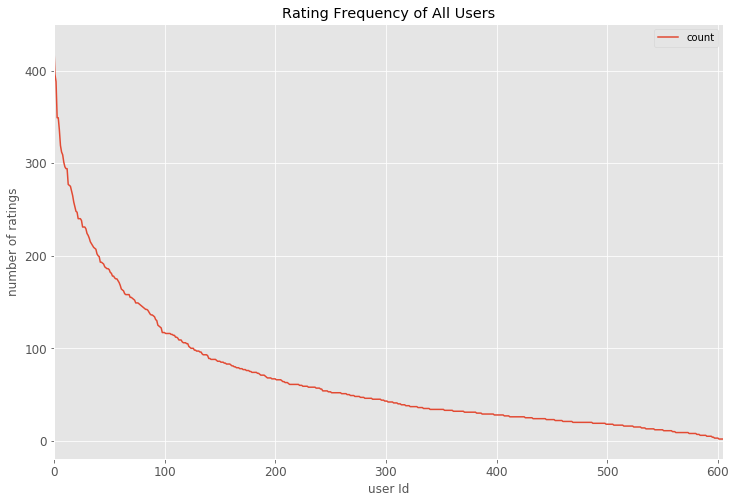

In [20]:
# plot rating frequency of all movies
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings")

In [21]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    429.00
0.95    223.50
0.90    166.00
0.85    134.25
0.80    105.00
0.75     85.00
0.70     74.00
0.65     62.25
0.60     56.00
0.55     48.00
Name: count, dtype: float64

In [22]:
'''
We can see that the distribution of ratings by users 
is very similar to the distribution of ratings among movies.

Only a very small fraction of users are very actively engaged with rating movies that they watched.
Vast majority of users aren't interested in rating movies. 
So we can limit users to the top 40%, which is about 113,291 users.
'''
# filter data
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (100836, 4)
shape of ratings data after dropping both unpopular movies and inactive users:  (32999, 4)


In [23]:
#KNN 하자
'''
1. reshaping the data
For K-Nearest Neighbors, we want the data to be in an (artist, user) array,
where each row is a movie and each column is a different user.
To reshape the dataframe, we'll pivot the dataframe to the wide format with movies
as rows and users as columns.
Then we'll fill the missing observations with 0s since
we're going to be performing linear algebra operations(calculating distances between vectors).
Finally, we transform the values of the dataframe into
a scipy sparse matrix for more efficient calculations.
'''
# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
# create mapper from movie title to index
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)
print(movie_user_mat_sparse)

  (0, 0)	4.0
  (0, 3)	4.5
  (0, 4)	2.5
  (0, 6)	4.5
  (0, 7)	3.5
  (0, 8)	4.0
  (0, 10)	3.5
  (0, 13)	3.0
  (0, 15)	3.0
  (0, 16)	3.0
  (0, 20)	5.0
  (0, 23)	5.0
  (0, 24)	4.0
  (0, 26)	3.0
  (0, 29)	5.0
  (0, 32)	5.0
  (0, 33)	4.0
  (0, 34)	4.0
  (0, 35)	2.5
  (0, 36)	4.5
  (0, 37)	0.5
  (0, 39)	2.5
  (0, 42)	3.0
  (0, 43)	4.0
  (0, 44)	3.0
  :	:
  (449, 94)	3.5
  (449, 108)	3.0
  (449, 114)	3.0
  (449, 115)	4.5
  (449, 125)	4.0
  (449, 135)	3.0
  (449, 138)	5.0
  (449, 152)	5.0
  (449, 155)	2.0
  (449, 158)	2.5
  (449, 165)	3.5
  (449, 173)	5.0
  (449, 182)	3.5
  (449, 184)	4.0
  (449, 201)	4.0
  (449, 212)	5.0
  (449, 221)	5.0
  (449, 229)	3.5
  (449, 231)	5.0
  (449, 238)	3.0
  (449, 239)	2.0
  (449, 249)	4.0
  (449, 255)	4.0
  (449, 257)	3.5
  (449, 267)	3.0


In [24]:
'''
2.fitting the model
Time to implement the model. 
We'll initialize the NearestNeighbors class as model_knn 
and fit our sparse matrix to the instance.
By specifying the metric = cosine,
the model will measure similarity bectween artist vectors by using cosine similarity.
'''
%env JOBLIB_TEMP_FOLDER=/tmp
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

env: JOBLIB_TEMP_FOLDER=/tmp


NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [25]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]



def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [26]:
my_favorite = 'spider man'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: spider man
Found possible matches in our database: ['Spider-Man (2002)', 'Spider-Man 2 (2004)']

Recommendation system start to make inference
......

Recommendations for spider man:
1: Bourne Identity, The (2002), with distance of 0.3051797459361082
2: Shrek (2001), with distance of 0.29291340466746485
3: Pirates of the Caribbean: The Curse of the Black Pearl (2003), with distance of 0.29289354703199477
4: X2: X-Men United (2003), with distance of 0.29059124991397633
5: Lord of the Rings: The Two Towers, The (2002), with distance of 0.285633932865471
6: X-Men (2000), with distance of 0.2777599092364813
7: Lord of the Rings: The Fellowship of the Ring, The (2001), with distance of 0.2767367743397827
8: Minority Report (2002), with distance of 0.27196530165992505
9: Star Wars: Episode II - Attack of the Clones (2002), with distance of 0.2631508376249241
10: Spider-Man 2 (2004), with distance of 0.23111363727142986


In [27]:
'''
KNN model
However, the cosine distance of all those recommendations are actually quite small.
This is probabily because there is too many zero values in our movie-user matrix.
With too many zero values in our data, the data sparsity becomes a real issue for KNN model and the distance in KNN model starts to fall apart.
So I'd like to dig deeper and look closer inside our data.
'''

"\nKNN model\nHowever, the cosine distance of all those recommendations are actually quite small.\nThis is probabily because there is too many zero values in our movie-user matrix.\nWith too many zero values in our data, the data sparsity becomes a real issue for KNN model and the distance in KNN model starts to fall apart.\nSo I'd like to dig deeper and look closer inside our data.\n"

In [63]:
'''
Let's now look at how sparse the movie-user matrix is by calculating percentage of zero values in the data.
'''

# calcuate total number of entries in the movie-user matrix
num_entries = movie_user_mat.shape[0] * movie_user_mat.shape[1]
# calculate total number of entries with zero values
num_zeros = (movie_user_mat==0).sum(axis=1).sum()
# calculate ratio of number of zeros to number of entries
ratio_zeros = num_zeros / num_entries
print('There is about {:.2%} of ratings in our data is missing'.format(ratio_zeros))

There is about 72.64% of ratings in our data is missing
